In [2]:
import os
import numpy as np
data = "/content/drive/MyDrive/Academic/Course Work/Masters YorkU/Fall 2023-24/EECS 6154 - DIP Theory and Algorithms/Project"
images = [im for im in os.listdir(data) if 'jpeg' in im]
# images
exd = "/content/drive/MyDrive/Academic/Course Work/Masters YorkU/Fall 2023-24/EECS 6154 - DIP Theory and Algorithms/Project/ExDark"
cont = os.listdir(exd)
test = "/content/drive/MyDrive/Academic/Course Work/Masters YorkU/Fall 2023-24/EECS 6154 - DIP Theory and Algorithms/Project/179.png"
test = "/content/drive/MyDrive/Academic/Course Work/Masters YorkU/Fall 2023-24/EECS 6154 - DIP Theory and Algorithms/Project/Project Codes/low-light.jpg"

In [ ]:
obj_dct = {}
for obj in cont:
  obj_dct[obj] = [os.path.join(exd, obj, val) for val in os.listdir(os.path.join(exd, obj))]
  print(obj_dct[obj])

To do:

Low light image enhancement:

**Apply retinex theory algorithm**

According to the Retinex theory, an observation S can
be represented by the pixelwise product of two different
components: a reflectance layer R and an illumination
layer L,

`S = R · L`

where R denotes the inherent property of the scene surface
and contains details and color information of the original
image, while L represents the intensity and distribution of the
environmental illumination. Note that L is spatially determined
by the darkened regions of the image.

Two Steps:

Optimization of Illumination:


Optimization of Reflectance:
The reflection function is piecewise constant. Therefore the TV is used as the regularization.






### Adaptive neighborhood size and Weighted average

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

images = [os.path.join(data, "eval15", "low", x) for x in os.listdir(os.path.join(data, "eval15", "low"))]

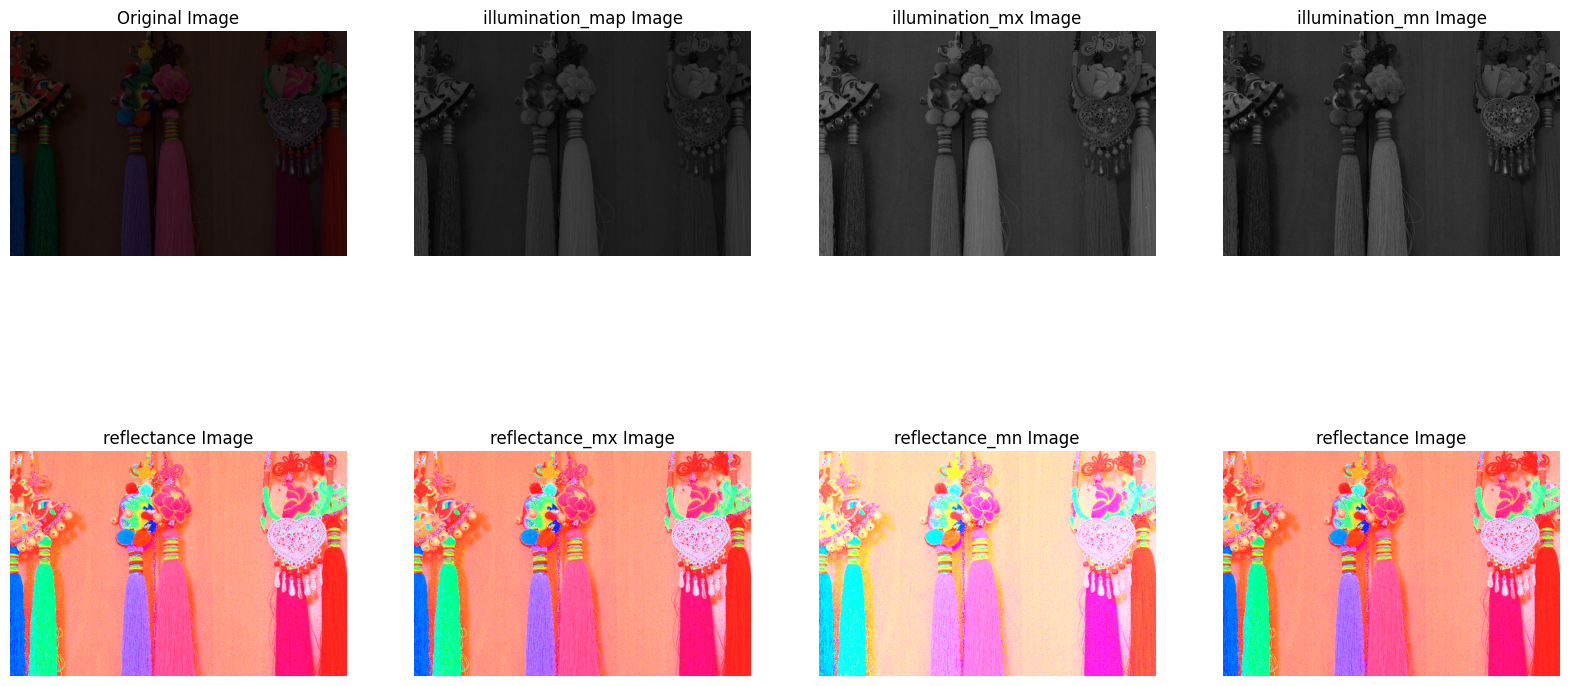

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# def estimate_illumination_map(image):
#     # Use np.max with axis=2 to find the maximum across the color channels (R, G, B)
#     illumination_map = np.max(image, axis=2)
#     return illumination_map

def adaptive_neighborhood_size(variance, threshold_low, threshold_high, sizes):
    # Choose neighborhood size based on variance
    if variance < threshold_low:
        return sizes['small']
    elif variance > threshold_high:
        return sizes['large']
    else:
        return sizes['medium']

def weighted_average(image, x, y, neighborhood_size):
    # Compute weighted average in the neighborhood
    kernel = np.ones((neighborhood_size, neighborhood_size), dtype=np.float32)
    kernel /= np.sum(kernel)  # Normalize the kernel
    start_x, end_x = max(0, x - neighborhood_size//2), min(image.shape[1], x + neighborhood_size//2 + 1)
    start_y, end_y = max(0, y - neighborhood_size//2), min(image.shape[0], y + neighborhood_size//2 + 1)
    neighborhood = image[start_y:end_y, start_x:end_x]
    return np.mean(neighborhood)

def construct_illumination_component(image, threshold_low, threshold_high, sizes):
    height, width = image.shape[:2]
    illumination_component = np.zeros_like(image)

    for y in range(height):
        for x in range(width):
            neighborhood_size = sizes['medium']  # Default size
            start_x, end_x = max(0, x - neighborhood_size//2), min(width, x + neighborhood_size//2 + 1)
            start_y, end_y = max(0, y - neighborhood_size//2), min(height, y + neighborhood_size//2 + 1)
            variance = np.var(image[start_y:end_y, start_x:end_x])
            neighborhood_size = adaptive_neighborhood_size(variance, threshold_low, threshold_high, sizes)
            if variance < threshold_low:
                illumination_component[y, x] = np.max(image[y, x])
            else:
                illumination_component[y, x] = weighted_average(image, x, y, neighborhood_size)

    return illumination_component


def estimate_reflectance(image, illumination_map):
    # Ensure the illumination map has the same number of dimensions as the image
    if illumination_map.ndim == 3:
        illumination_map = illumination_map[:, :, 0]  # Remove the extra dimension

    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        reflectance = image / illumination_map[:, :, None]  # Add the channel dimension for division
        reflectance[~np.isfinite(reflectance)] = 0  # Replace infinities and NaNs with 0

    return reflectance

def display_images(images, titles):
    plt.figure(figsize=(20, 12))
    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        if len(image.shape) == 2:
            plt.imshow(image, cmap='gray')
        else:
            plt.imshow(image)
        plt.title(title)
        plt.axis('off')
    plt.show()

# Path to your low-light image
image_path = images[4]
# Load the image
image = cv2.imread(image_path, cv2.IMREAD_COLOR)

if image is None:
    print("Error loading image")
else:
    # Convert BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert image to float32 for more precision in calculations
    image_float = np.float32(image_rgb) / 255.0


    # Construct the illumination component
    variance_threshold_low = 50  # Example low threshold for variance
    variance_threshold_high = 300  # Example high threshold for variance
    neighborhood_sizes = {'small': 3, 'medium': 5, 'large': 7}
    illumination_map = construct_illumination_component(image_float, variance_threshold_low, variance_threshold_high, neighborhood_sizes)
    illumination_mx = np.max(image_float, axis=2)
    illumination_mn = np.mean(image_float, axis=2)
    # print(illumination_map.shape)
    # Estimate the reflectance component
    reflectance = estimate_reflectance(image_float, illumination_map)
    reflectance_mx = estimate_reflectance(image_float, illumination_mx)
    reflectance_mn = estimate_reflectance(image_float, illumination_mn)


    # Display the original RGB image, illumination map, and the reflectance component
    # display_images([image_rgb, illumination_map, reflectance, illumination_mx, reflectance_mx, illumination_mn, reflectance_mn], ["Original RGB Image", "Illumination Map", "Reflectance Component", "Illumination Max", "Reflectance Max", "Illumination Mean", "Reflectance Mean"])

# Display the original and final images
plt.figure(figsize=(20, 10))

# Original image
plt.subplot(2, 4, 1)
plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')

# Final (processed) image
plt.subplot(2, 4, 2)
plt.imshow(np.clip(illumination_map, 0, 1), cmap='gray')  # Clip values to valid range [0, 1]
plt.title('illumination_map Image')
plt.axis('off')

plt.subplot(2, 4, 3)
plt.imshow(np.clip(illumination_mx, 0, 1), cmap='gray')  # Clip values to valid range [0, 1]
plt.title('illumination_mx Image')
plt.axis('off')

plt.subplot(2, 4, 4)
plt.imshow(np.clip(illumination_mn, 0, 1), cmap='gray')  # Clip values to valid range [0, 1]
plt.title('illumination_mn Image')
plt.axis('off')

# Final (processed) image
plt.subplot(2, 4, 5)
plt.imshow(np.clip(reflectance, 0, 1))  # Clip values to valid range [0, 1]
plt.title('reflectance Image')
plt.axis('off')

plt.subplot(2, 4, 6)
plt.imshow(np.clip(reflectance_mx, 0, 1))  # Clip values to valid range [0, 1]
plt.title('reflectance_mx Image')
plt.axis('off')

plt.subplot(2, 4, 7)
plt.imshow(np.clip(reflectance_mn, 0, 1))  # Clip values to valid range [0, 1]
plt.title('reflectance_mn Image')
plt.axis('off')

plt.subplot(2, 4, 8)
plt.imshow(np.clip(reflectance, 0, 1))  # Clip values to valid range [0, 1]
plt.title('reflectance Image')
plt.axis('off')

plt.show()

### FINAL PASS WITH ADAPTIVE AND WEIGHTED

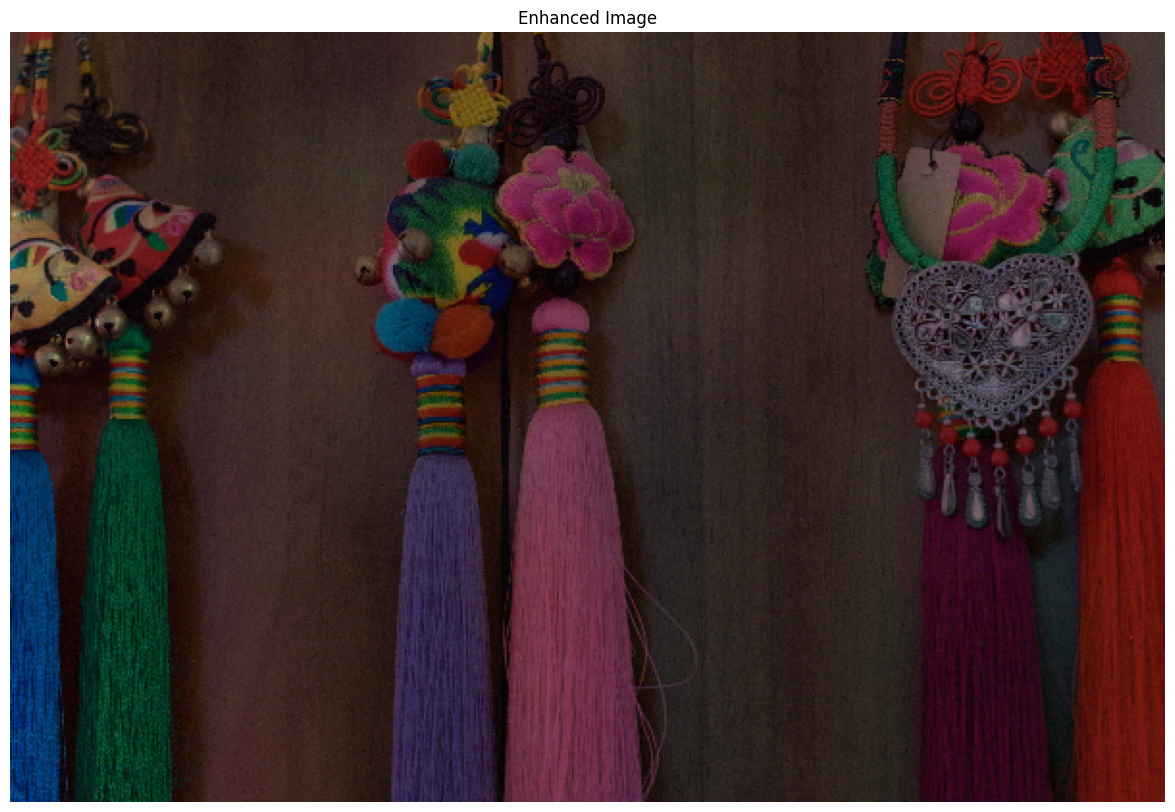

In [ ]:
import matplotlib.pyplot as plt
import imageio
import numpy as np
from skimage.restoration import denoise_tv_chambolle
from scipy.ndimage import gaussian_filter

# Load the color image
# Decompose the image
# image_path = obj_dct[cont[6]][30]
image_path = images[4]
# Load the image
image = cv2.imread(image_path, cv2.IMREAD_COLOR)
# image = cv2.resize(image, (20, 20), interpolation=cv2.INTER_LINEAR)



def adaptive_neighborhood_size(variance, variance_threshold, sizes):
    # Choose neighborhood size based on variance
    if variance > variance_threshold:
        return sizes['small']
    else:
        return sizes['medium']

def weighted_average(image, x, y, neighborhood_size):
    # Compute weighted average in the neighborhood
    kernel = np.ones((neighborhood_size, neighborhood_size), dtype=np.float32)
    kernel /= np.sum(kernel)  # Normalize the kernel
    start_x, end_x = max(0, x - neighborhood_size//2), min(image.shape[1], x + neighborhood_size//2 + 1)
    start_y, end_y = max(0, y - neighborhood_size//2), min(image.shape[0], y + neighborhood_size//2 + 1)
    neighborhood = image[start_y:end_y, start_x:end_x]
    return np.mean(neighborhood)

def construct_illumination_component(image, variance_threshold, sizes):
    height, width = image.shape[:2]
    illumination_component = np.zeros_like(image)

    for y in range(height):
        for x in range(width):
            neighborhood_size = sizes['medium']  # Default size
            start_x, end_x = max(0, x - neighborhood_size//2), min(width, x + neighborhood_size//2 + 1)
            start_y, end_y = max(0, y - neighborhood_size//2), min(height, y + neighborhood_size//2 + 1)
            variance = np.var(image[start_y:end_y, start_x:end_x])
            neighborhood_size = adaptive_neighborhood_size(variance, variance_threshold, sizes)
            if neighborhood_size > sizes['small']:
                illumination_component[y, x] = np.max(image[y, x])
            else:
                illumination_component[y, x] = weighted_average(image, x, y, neighborhood_size)

    return illumination_component


# def estimate_reflectance(image, illumination_map):
#     # Ensure the illumination map has the same number of dimensions as the image
#     if illumination_map.ndim == 3:
#         illumination_map = illumination_map[:, :, 0]  # Remove the extra dimension

#     # Avoid division by zero
#     with np.errstate(divide='ignore', invalid='ignore'):
#         reflectance = image / illumination_map[:, :, None]  # Add the channel dimension for division
#         reflectance[~np.isfinite(reflectance)] = 0  # Replace infinities and NaNs with 0

#     return reflectance

def estimate_reflectance(image, illumination_map):
    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        reflectance = image / illumination_map[:, :, None]
        reflectance[~np.isfinite(reflectance)] = 0  # Replace infinities and NaNs with 0
    return reflectance

# TV-ADMM denoising (using skimage's denoise_tv_chambolle as a placeholder)
def tv_admm_denoising(reflectance, weight=0.2):
    denoised = np.zeros_like(reflectance)
    for i in range(reflectance.shape[2]):  # Apply denoising channel-wise
        denoised[:, :, i] = denoise_tv_chambolle(reflectance[:, :, i], weight=weight, channel_axis=False)
    return denoised

# Tikhonov regularization for illumination enhancement
def enhance_illumination_tikh(illumination, lambda_reg=1.0, num_iter=100, learning_rate=0.01):
    enhanced_illumination = np.copy(illumination)

    for _ in range(num_iter):
        grad = 2 * (enhanced_illumination - illumination)  # Data fidelity term
        grad += 2 * lambda_reg * gaussian_filter(enhanced_illumination, sigma=2, order=2)  # Regularization term
        enhanced_illumination -= learning_rate * grad

    return enhanced_illumination


# def enhance_illumination_cl(image):

#     # Apply histogram equalization to the illumination map
#     # Convert to 8-bit for histogram equalization
#     illumination_map_8bit = (image * 255).astype(np.uint8)
#     # equalized_illumination = cv2.equalizeHist(illumination_map_8bit) / 255.0
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#     equalized_illumination = clahe.apply(illumination_map_8bit) / 255.0

#     return equalized_illumination

def enhance_illumination_cl(image):
    # Initialize an empty array to store the enhanced channels
    enhanced_channels = []

    # Loop through each channel in the image
    for i in range(3):  # Assuming image has 3 channels (RGB)
        # Extract the current channel
        channel = image[:, :, i]

        # Apply histogram equalization to the channel
        channel_8bit = (channel * 255).astype(np.uint8)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        equalized_channel = clahe.apply(channel_8bit) / 255.0

        # Append the enhanced channel to the list
        enhanced_channels.append(equalized_channel)

    # Stack the enhanced channels back into an image
    enhanced_image = np.stack(enhanced_channels, axis=-1)

    return enhanced_image

def apply_gamma_correction(image, gamma=1.5):
    # Apply gamma correction
    gamma_corrected = np.power(image, gamma)
    return gamma_corrected


max_var = -np.inf
min_var = np.inf


if image is None:
    print("Error loading image")
else:
    # Convert BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert image to float32 for more precision in calculations
    image_float = np.float32(image_rgb) / 255.0


    # Construct the illumination component
    # variance_threshold = 300  # Example high threshold for variance
    # neighborhood_sizes = {'small': 3, 'medium': 5, 'large': 7}
    # illumination_map = construct_illumination_component(image_float, variance_threshold, neighborhood_sizes)
    illumination_map = np.mean(image_float, axis=2)

    # print(f"MX: {max_var}, MN: {min_var}")
    # Estimate the reflectance component
    reflectance = estimate_reflectance(image_float, illumination_map)


# Enhance the reflectance component using TV-ADMM denoising
enhanced_reflectance = tv_admm_denoising(reflectance, weight=0.25)

# reflectance_gamma_corrected = apply_gamma_correction(enhanced_reflectance, gamma=0.2)

# print(illumination.shape)
# # Apply Tikhonov regularization to the illumination component

# enhanced_illumination = enhance_illumination_cl(illumination.squeeze())

lambda_reg = 0.25  # Example value for lambda
enhanced_illumination = enhance_illumination_tikh(illumination_map.squeeze(), lambda_reg)
# print(enhanced_reflectance.shape)
# illumination_gamma_corrected = apply_gamma_correction(enhanced_illumination)
# Recombine the components
# final_image = enhanced_reflectance * enhanced_illumination
final_image = enhanced_reflectance * enhanced_illumination[:, :, np.newaxis]
final_image = enhance_illumination_cl(final_image.squeeze())
# final_image = enhanced_reflectance * illumination_gamma_corrected[:, :, np.newaxis]

# Display the original and final images
plt.figure(figsize=(20, 10))

# Original image
# plt.subplot(1, 4, 1)
# plt.imshow(image_rgb)
# plt.title('Original Image')
# plt.axis('off')

# Final (processed) image
# plt.subplot(1, 4, 2)
plt.imshow(final_image)  # Clip values to valid range [0, 1]
plt.title('Enhanced Image')
plt.savefig(os.path.join(data, "Project Codes", "Results", "final_image_mean.png"), dpi=400)
plt.axis('off')

# Final (processed) image
# plt.subplot(1, 4, 3)
# plt.imshow(enhanced_illumination, cmap="gray")  # Clip values to valid range [0, 1]
# plt.title('enhanced_illumination Image')
# # plt.savefig(os.path.join(data, "Project Codes", "Results", "enhc_illm.png"), dpi=400)
# plt.axis('off')

# plt.subplot(1, 4, 4)
# plt.imshow(enhanced_reflectance)  # Clip values to valid range [0, 1]
# plt.title('enhanced_reflectance Image')
# # plt.savefig(os.path.join(data, "Project Codes", "Results", "enhc_refl.png"), dpi=400)
# plt.axis('off')

plt.show()

### Result Generation

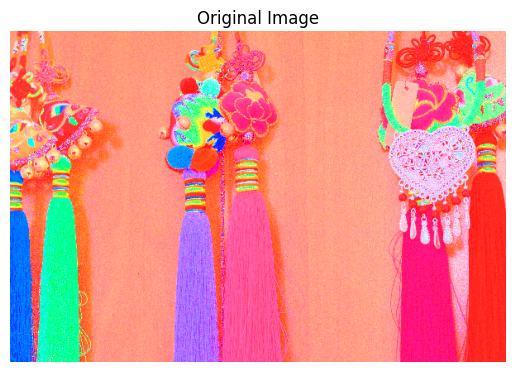

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def adaptive_neighborhood_size(variance, variance_threshold, sizes):
    # Choose neighborhood size based on variance
    if variance > variance_threshold:
        return sizes['small']
    else:
        return sizes['medium']

def weighted_average(image, x, y, neighborhood_size):
    # Compute weighted average in the neighborhood
    kernel = np.ones((neighborhood_size, neighborhood_size), dtype=np.float32)
    kernel /= np.sum(kernel)  # Normalize the kernel
    start_x, end_x = max(0, x - neighborhood_size//2), min(image.shape[1], x + neighborhood_size//2 + 1)
    start_y, end_y = max(0, y - neighborhood_size//2), min(image.shape[0], y + neighborhood_size//2 + 1)
    neighborhood = image[start_y:end_y, start_x:end_x]
    return np.mean(neighborhood)

def construct_illumination_component(image, variance_threshold, sizes):
    height, width = image.shape[:2]
    illumination_component = np.zeros_like(image)

    for y in range(height):
        for x in range(width):
            neighborhood_size = sizes['medium']  # Default size
            start_x, end_x = max(0, x - neighborhood_size//2), min(width, x + neighborhood_size//2 + 1)
            start_y, end_y = max(0, y - neighborhood_size//2), min(height, y + neighborhood_size//2 + 1)
            variance = np.var(image[start_y:end_y, start_x:end_x])
            neighborhood_size = adaptive_neighborhood_size(variance, variance_threshold, sizes)
            if neighborhood_size > sizes['small']:
                illumination_component[y, x] = np.max(image[y, x])
            else:
                illumination_component[y, x] = weighted_average(image, x, y, neighborhood_size)

    return illumination_component


def estimate_reflectance(image, illumination_map):
    # Ensure the illumination map has the same number of dimensions as the image
    if illumination_map.ndim == 3:
        illumination_map = illumination_map[:, :, 0]  # Remove the extra dimension

    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        reflectance = image / illumination_map[:, :, None]  # Add the channel dimension for division
        reflectance[~np.isfinite(reflectance)] = 0  # Replace infinities and NaNs with 0

    return reflectance


def display_images(images, titles):
    plt.figure(figsize=(15, 5))
    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        if len(image.shape) == 2:
            plt.imshow(image, cmap='gray')
        else:
            plt.imshow(image)
        plt.title(title)
        plt.axis('off')
    plt.show()

# Path to your low-light image
image_path = images[4]
# Load the image
image = cv2.imread(image_path, cv2.IMREAD_COLOR)

if image is None:
    print("Error loading image")
else:
    # Convert BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert image to float32 for more precision in calculations
    image_float = np.float32(image_rgb) / 255.0

    # Estimate the illumination map
    # illumination_map = estimate_illumination_map(image_float)
    # Parameters
    variance_threshold = 300  # Example high threshold for variance
    neighborhood_sizes = {'small': 3, 'medium': 5, 'large': 7}
    illumination_map = construct_illumination_component(image_float, variance_threshold, neighborhood_sizes)

    # Construct the illumination component
    # illumination_map = construct_illumination_component(image_float, neighborhood_size, variance_threshold)
    # illumination_map = np.mean(image_float, axis=2)
    # Estimate the reflectance component
    reflectance = estimate_reflectance(image_float, illumination_map)

    # Display the original RGB image, illumination map, and the reflectance component
    # display_images([image_rgb, illumination_map, reflectance], ["Original RGB Image", "Illumination Map", "Reflectance Component"])
# plt.imshow(illumination_map, cmap="gray")
plt.imshow(reflectance)
plt.title('Original Image')
plt.axis('off')
plt.savefig(os.path.join(data, "Project Codes", "Results", "refl_at300.png"), dpi=400)
plt.show()

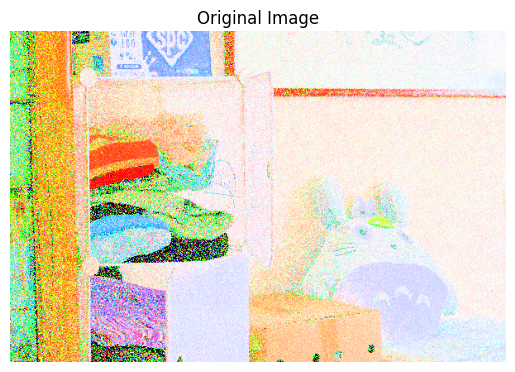

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def calculate_neighborhood_variance(image, x, y, neighborhood_size):
    """
    Calculate the variance of pixel values in the neighborhood of (x, y)
    """
    row_start = max(y - neighborhood_size, 0)
    row_end = min(y + neighborhood_size + 1, image.shape[0])
    col_start = max(x - neighborhood_size, 0)
    col_end = min(x + neighborhood_size + 1, image.shape[1])

    neighborhood = image[row_start:row_end, col_start:col_end]
    variance = np.var(neighborhood, axis=(0, 1))
    return variance

def construct_illumination_component(image, neighborhood_size, variance_threshold):
    """
    Construct the illumination component based on neighborhood variance
    """

    height, width, _ = image.shape
    illumination_component = np.zeros((height, width))
    # height, width = image.shape
    # illumination_component = np.zeros_like(image)

    for y in range(height):
        for x in range(width):
            variance = calculate_neighborhood_variance(image, x, y, neighborhood_size)
            if np.all(variance < variance_threshold):
                illumination_component[y, x] = np.max(image[y, x])
            else:
                # Calculate average value of the neighborhood
                row_start = max(y - neighborhood_size, 0)
                row_end = min(y + neighborhood_size + 1, height)
                col_start = max(x - neighborhood_size, 0)
                col_end = min(x + neighborhood_size + 1, width)
                neighborhood = image[row_start:row_end, col_start:col_end]
                illumination_component[y, x] = np.mean(neighborhood)

    return illumination_component


def estimate_reflectance(image, illumination_map):
    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        reflectance = image / illumination_map[:, :, None]
        reflectance[~np.isfinite(reflectance)] = 0  # Replace infinities and NaNs with 0
    return reflectance

def display_images(images, titles):
    plt.figure(figsize=(15, 5))
    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        if len(image.shape) == 2:
            plt.imshow(image, cmap='gray')
        else:
            plt.imshow(image)
        plt.title(title)
        plt.axis('off')
    plt.show()

# Path to your low-light image
image_path = images[6]
# Load the image
image = cv2.imread(image_path, cv2.IMREAD_COLOR)

if image is None:
    print("Error loading image")
else:
    # Convert BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert image to float32 for more precision in calculations
    image_float = np.float32(image_rgb) / 255.0

    # Estimate the illumination map
    # illumination_map = estimate_illumination_map(image_float)
    # Parameters
    neighborhood_size = 5  # Example size, can be adjusted
    variance_threshold = 300  # Example threshold, can be adjusted

    # Construct the illumination component
    illumination_map = construct_illumination_component(image_float, neighborhood_size, variance_threshold)
    # illumination_map = np.mean(image_float, axis=2)
    # Estimate the reflectance component
    reflectance = estimate_reflectance(image_float, illumination_map)

    # Display the original RGB image, illumination map, and the reflectance component
    # display_images([image_rgb, illumination_map, reflectance], ["Original RGB Image", "Illumination Map", "Reflectance Component"])
plt.imshow(reflectance)
plt.title('Original Image')
plt.axis('off')
plt.savefig(os.path.join(data, "Project Codes", "Results", "refl_at300.png"), dpi=400)
plt.show()

images: 4, 2, 6

## FINAL PASS WITHOUT ADAPTIVE AND WEIGHTED

In [7]:
import matplotlib.pyplot as plt
import imageio
import numpy as np
from skimage.restoration import denoise_tv_chambolle
from scipy.ndimage import gaussian_filter

# Load the color image
# Decompose the image
# image_path = obj_dct[cont[6]][30]
image_path = images[4]
# Load the image
image = cv2.imread(image_path, cv2.IMREAD_COLOR)
# image = cv2.resize(image, (20, 20), interpolation=cv2.INTER_LINEAR)



def calculate_neighborhood_variance(image, x, y, neighborhood_size, max_var, min_var):
    """
    Calculate the variance of pixel values in the neighborhood of (x, y)
    """
    row_start = max(y - neighborhood_size, 0)
    row_end = min(y + neighborhood_size + 1, image.shape[0])
    col_start = max(x - neighborhood_size, 0)
    col_end = min(x + neighborhood_size + 1, image.shape[1])

    neighborhood = image[row_start:row_end, col_start:col_end]
    variance = np.var(neighborhood, axis=(0, 1))
    if np.max(variance) > max_var:
      max_var = np.max(variance)
    if np.min(variance) <= min_var:
      min_var = np.min(variance)
    return variance, max_var, min_var

def construct_illumination_component(image, neighborhood_size, variance_threshold, max_var, min_var):
    """
    Construct the illumination component based on neighborhood variance
    """
    height, width, _ = image.shape
    illumination_component = np.zeros((height, width))

    for y in range(height):
        for x in range(width):
            variance, max_var, min_var = calculate_neighborhood_variance(image, x, y, neighborhood_size, max_var, min_var)
            # print(f"MX: {max_var}, MN: {min_var}")
            # if np.all(variance >= variance_threshold):
            #   print(f"[X, y]: {x, y}, variance: {variance}")
            if np.all(variance < variance_threshold):
                illumination_component[y, x] = np.max(image[y, x])
            else:
                # Calculate average value of the neighborhood
                row_start = max(y - neighborhood_size, 0)
                row_end = min(y + neighborhood_size + 1, height)
                col_start = max(x - neighborhood_size, 0)
                col_end = min(x + neighborhood_size + 1, width)
                neighborhood = image[row_start:row_end, col_start:col_end]
                illumination_component[y, x] = np.mean(neighborhood)

    return illumination_component, max_var, min_var


# Placeholder for Retinex decomposition
def estimate_illumination_map(image):
    # Use np.max with axis=2 to find the maximum across the color channels (R, G, B)
    illumination_map = np.max(image, axis=2)
    return illumination_map

def estimate_reflectance(image, illumination_map):
    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        reflectance = image / illumination_map[:, :, None]
        reflectance[~np.isfinite(reflectance)] = 0  # Replace infinities and NaNs with 0
    return reflectance

# TV-ADMM denoising (using skimage's denoise_tv_chambolle as a placeholder)
def tv_admm_denoising(reflectance, weight=0.2):
    denoised = np.zeros_like(reflectance)
    for i in range(reflectance.shape[2]):  # Apply denoising channel-wise
        denoised[:, :, i] = denoise_tv_chambolle(reflectance[:, :, i], weight=weight, channel_axis=False)
    return denoised


from scipy.spatial.distance import euclidean

def bilateral_filter(image, sigma_s, sigma_r, neighborhood_size):
    """
    Apply a bilateral filter to an image.

    :param image: Input image (grayscale or single channel)
    :param sigma_s: Spatial/kernel standard deviation
    :param sigma_r: Range/kernel standard deviation
    :param neighborhood_size: Size of the neighborhood around each pixel
    :return: Filtered image
    """
    # Define the output image
    filtered_image = np.zeros_like(image, dtype=np.float32)

    # Iterate over each pixel in the image
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            # Define the neighborhood
            y_min = max(y - neighborhood_size, 0)
            y_max = min(y + neighborhood_size + 1, image.shape[0])
            x_min = max(x - neighborhood_size, 0)
            x_max = min(x + neighborhood_size + 1, image.shape[1])

            # Initialize the normalization factor
            W = 0

            # Initialize the filtered pixel value
            I_filtered = 0

            # Iterate over each pixel in the neighborhood
            for ny in range(y_min, y_max):
                for nx in range(x_min, x_max):
                    # Calculate the spatial distance
                    d_spatial = euclidean([y, x], [ny, nx])

                    # Calculate the intensity difference
                    d_intensity = abs(int(image[y, x]) - int(image[ny, nx]))

                    # Calculate the weights
                    w = np.exp(-d_spatial**2 / (2 * sigma_s**2)) * np.exp(-d_intensity**2 / (2 * sigma_r**2))

                    # Accumulate the weighted intensity
                    I_filtered += image[ny, nx] * w

                    # Accumulate the normalization factor
                    W += w

            # Normalize the filtered pixel value
            filtered_image[y, x] = I_filtered / W if W > 0 else image[y, x]

    return filtered_image

# Tikhonov regularization for illumination enhancement
# def enhance_illumination_tikh(illumination, lambda_reg=1.0, num_iter=100, learning_rate=0.01):
#     enhanced_illumination = np.copy(illumination)

#     for _ in range(num_iter):
#         grad = 2 * (enhanced_illumination - illumination)  # Data fidelity term
#         grad += 2 * lambda_reg * gaussian_filter(enhanced_illumination, sigma=2, order=2)  # Regularization term
#         enhanced_illumination -= learning_rate * grad

#     return enhanced_illumination


def enhance_illumination_tikh(image, sigma_s, sigma_r, neighborhood_size, lambda_reg, num_iter=100, learning_rate=0.01):
    enhanced_illumination = np.copy(image)

    for _ in range(num_iter):
        grad = 2 * (enhanced_illumination - illumination)  # Data fidelity term
        grad += 2 * lambda_reg * bilateral_filter(image, sigma_s, sigma_r, neighborhood_size)  # Regularization term
        enhanced_illumination -= learning_rate * grad

    return enhanced_illumination


# def enhance_illumination_cl(image):

#     # Apply histogram equalization to the illumination map
#     # Convert to 8-bit for histogram equalization
#     illumination_map_8bit = (image * 255).astype(np.uint8)
#     # equalized_illumination = cv2.equalizeHist(illumination_map_8bit) / 255.0
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#     equalized_illumination = clahe.apply(illumination_map_8bit) / 255.0

#     return equalized_illumination

def enhance_illumination_cl(image):
    # Initialize an empty array to store the enhanced channels
    enhanced_channels = []

    # Loop through each channel in the image
    for i in range(3):  # Assuming image has 3 channels (RGB)
        # Extract the current channel
        channel = image[:, :, i]

        # Apply histogram equalization to the channel
        channel_8bit = (channel * 255).astype(np.uint8)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        equalized_channel = clahe.apply(channel_8bit) / 255.0

        # Append the enhanced channel to the list
        enhanced_channels.append(equalized_channel)

    # Stack the enhanced channels back into an image
    enhanced_image = np.stack(enhanced_channels, axis=-1)

    return enhanced_image

def apply_gamma_correction(image, gamma=1.5):
    # Apply gamma correction
    gamma_corrected = np.power(image, gamma)
    return gamma_corrected


max_var = -np.inf
min_var = np.inf


if image is None:
    print("Error loading image")
else:
    # Convert BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert image to float32 for more precision in calculations
    image_float = np.float32(image_rgb) / 255.0

    # Estimate the illumination map
    neighborhood_size = 5  # Example size, can be adjusted
    variance_threshold = 300  # Example threshold, can be adjusted
    # illumination = estimate_illumination_map(image_float)
    illumination, max_var, min_var = construct_illumination_component(image_rgb, neighborhood_size, variance_threshold, max_var, min_var)

    # print(f"MX: {max_var}, MN: {min_var}")
    illumination = np.float32(illumination) / 255.0
    # Estimate the reflectance component
    reflectance = estimate_reflectance(image_float, illumination)


# Enhance the reflectance component using TV-ADMM denoising
enhanced_reflectance = tv_admm_denoising(reflectance, weight=0.25)

# reflectance_gamma_corrected = apply_gamma_correction(enhanced_reflectance, gamma=0.2)

# print(illumination.shape)
# # Apply Tikhonov regularization to the illumination component

# enhanced_illumination = enhance_illumination_cl(illumination.squeeze())

lambda_reg = 0.25  # Example value for lambda
sigma_s = 0.2  # Spatial standard deviation
sigma_r = 1  # Range standard deviation
neighborhood_size = 2  # Neighborhood size (radius)
# enhanced_illumination = enhance_illumination_tikh(illumination.squeeze(), lambda_reg)
# enhanced_illumination = enhance_illumination_tikh(illumination.squeeze(), lambda_reg)
enhanced_illumination = enhance_illumination_tikh(illumination.squeeze(), sigma_s, sigma_r, neighborhood_size, lambda_reg)
# illumination_gamma_corrected = apply_gamma_correction(enhanced_illumination)
# Recombine the components
final_image = enhanced_reflectance * enhanced_illumination[:, :, np.newaxis]
final_image = enhance_illumination_cl(final_image.squeeze())
# final_image = enhanced_reflectance * illumination_gamma_corrected[:, :, np.newaxis]

# Display the original and final images
plt.figure(figsize=(20, 10))

# # Original image
plt.subplot(1, 4, 1)
plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')

# Final (processed) image
plt.subplot(1, 4, 2)
plt.imshow(final_image)  # Clip values to valid range [0, 1]
plt.title('Enhanced Image')
# plt.savefig(os.path.join(data, "Project Codes", "Results", "final_pr_woad.png"), dpi=400)
plt.axis('off')

# Final (processed) image
plt.subplot(1, 4, 3)
plt.imshow(np.clip(enhanced_illumination, 0, 1))  # Clip values to valid range [0, 1]
plt.title('enhanced_illumination Image')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(np.clip(enhanced_reflectance, 0, 1))  # Clip values to valid range [0, 1]
plt.title('enhanced_reflectance Image')
plt.axis('off')

plt.show()

KeyboardInterrupt: ignored

## Final Pass with Adaptive and Weighted

(-0.5, 599.5, 399.5, -0.5)

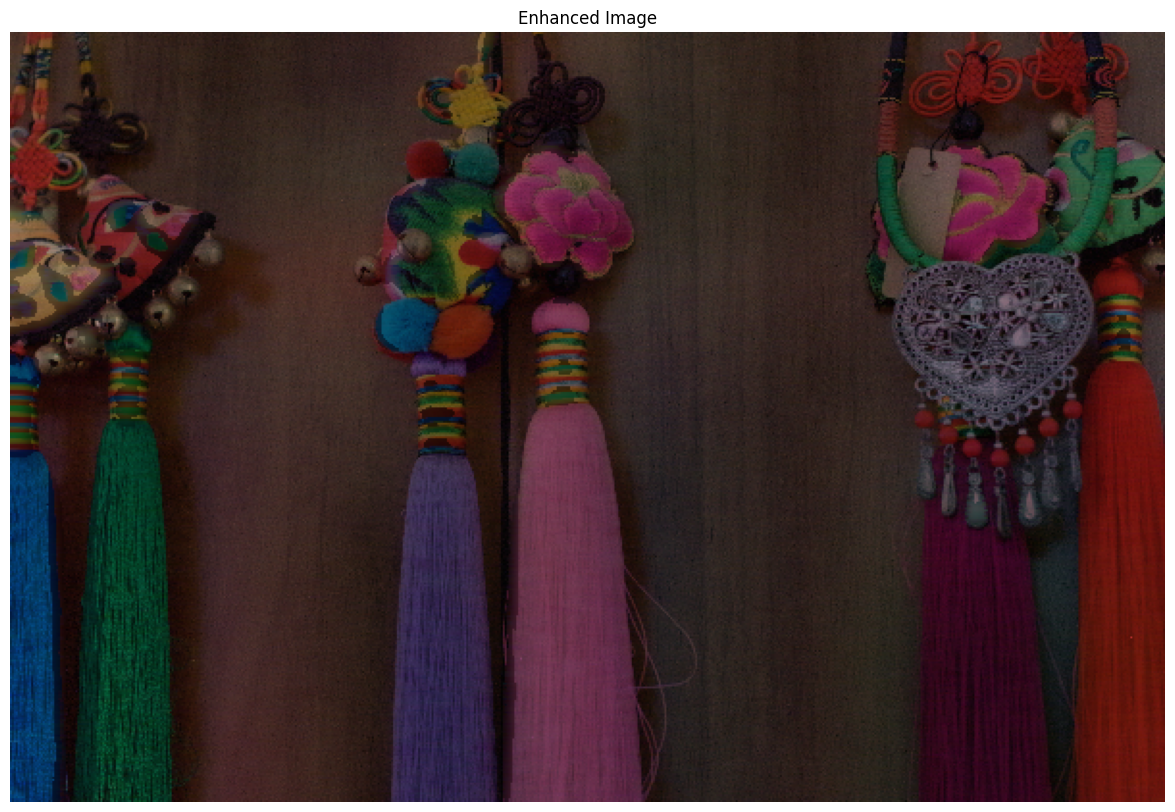

In [ ]:
import matplotlib.pyplot as plt
import imageio
import numpy as np
from skimage.restoration import denoise_tv_chambolle
from scipy.ndimage import gaussian_filter

# Load the color image
# Decompose the image
# image_path = obj_dct[cont[6]][30]
image_path = images[4]
# Load the image
image = cv2.imread(image_path, cv2.IMREAD_COLOR)
# image = cv2.resize(image, (20, 20), interpolation=cv2.INTER_LINEAR)



def adaptive_neighborhood_size(variance, variance_threshold, sizes):
    # Choose neighborhood size based on variance
    if variance > variance_threshold:
        return sizes['small']
    else:
        return sizes['medium']

def weighted_average(image, x, y, neighborhood_size):
    # Compute weighted average in the neighborhood
    kernel = np.ones((neighborhood_size, neighborhood_size), dtype=np.float32)
    kernel /= np.sum(kernel)  # Normalize the kernel
    start_x, end_x = max(0, x - neighborhood_size//2), min(image.shape[1], x + neighborhood_size//2 + 1)
    start_y, end_y = max(0, y - neighborhood_size//2), min(image.shape[0], y + neighborhood_size//2 + 1)
    neighborhood = image[start_y:end_y, start_x:end_x]
    return np.mean(neighborhood)

def construct_illumination_component(image, variance_threshold, sizes):
    height, width = image.shape[:2]
    illumination_component = np.zeros_like(image)

    for y in range(height):
        for x in range(width):
            neighborhood_size = sizes['medium']  # Default size
            start_x, end_x = max(0, x - neighborhood_size//2), min(width, x + neighborhood_size//2 + 1)
            start_y, end_y = max(0, y - neighborhood_size//2), min(height, y + neighborhood_size//2 + 1)
            variance = np.var(image[start_y:end_y, start_x:end_x])
            neighborhood_size = adaptive_neighborhood_size(variance, variance_threshold, sizes)
            if neighborhood_size > sizes['small']:
                illumination_component[y, x] = np.max(image[y, x])
            else:
                illumination_component[y, x] = weighted_average(image, x, y, neighborhood_size)

    return illumination_component


def estimate_reflectance(image, illumination_map):
    # Ensure the illumination map has the same number of dimensions as the image
    if illumination_map.ndim == 3:
        illumination_map = illumination_map[:, :, 0]  # Remove the extra dimension

    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        reflectance = image / illumination_map[:, :, None]  # Add the channel dimension for division
        reflectance[~np.isfinite(reflectance)] = 0  # Replace infinities and NaNs with 0

    return reflectance

# TV-ADMM denoising (using skimage's denoise_tv_chambolle as a placeholder)
def tv_admm_denoising(reflectance, weight=0.2):
    denoised = np.zeros_like(reflectance)
    for i in range(reflectance.shape[2]):  # Apply denoising channel-wise
        denoised[:, :, i] = denoise_tv_chambolle(reflectance[:, :, i], weight=weight, channel_axis=False)
    return denoised

# Tikhonov regularization for illumination enhancement
def enhance_illumination_tikh(illumination, lambda_reg=1.0, num_iter=100, learning_rate=0.01):
    enhanced_illumination = np.copy(illumination)

    for _ in range(num_iter):
        grad = 2 * (enhanced_illumination - illumination)  # Data fidelity term
        grad += 2 * lambda_reg * gaussian_filter(enhanced_illumination, sigma=2, order=2)  # Regularization term
        enhanced_illumination -= learning_rate * grad

    return enhanced_illumination


# def enhance_illumination_cl(image):

#     # Apply histogram equalization to the illumination map
#     # Convert to 8-bit for histogram equalization
#     illumination_map_8bit = (image * 255).astype(np.uint8)
#     # equalized_illumination = cv2.equalizeHist(illumination_map_8bit) / 255.0
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#     equalized_illumination = clahe.apply(illumination_map_8bit) / 255.0

#     return equalized_illumination

def enhance_illumination_cl(image):
    # Initialize an empty array to store the enhanced channels
    enhanced_channels = []

    # Loop through each channel in the image
    for i in range(3):  # Assuming image has 3 channels (RGB)
        # Extract the current channel
        channel = image[:, :, i]

        # Apply histogram equalization to the channel
        channel_8bit = (channel * 255).astype(np.uint8)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        equalized_channel = clahe.apply(channel_8bit) / 255.0

        # Append the enhanced channel to the list
        enhanced_channels.append(equalized_channel)

    # Stack the enhanced channels back into an image
    enhanced_image = np.stack(enhanced_channels, axis=-1)

    return enhanced_image

def apply_gamma_correction(image, gamma=1.5):
    # Apply gamma correction
    gamma_corrected = np.power(image, gamma)
    return gamma_corrected


max_var = -np.inf
min_var = np.inf


if image is None:
    print("Error loading image")
else:
    # Convert BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert image to float32 for more precision in calculations
    image_float = np.float32(image_rgb) / 255.0

    # Estimate the illumination map
    variance_threshold = 300  # Example high threshold for variance
    neighborhood_sizes = {'small': 3, 'medium': 5, 'large': 7}
    illumination_map = construct_illumination_component(image_float, variance_threshold, neighborhood_sizes)

    # print(f"MX: {max_var}, MN: {min_var}")
    # illumination = np.float32(illumination_map) / 255.0
    # Estimate the reflectance component
    reflectance = estimate_reflectance(image_float, illumination_map)


# Enhance the reflectance component using TV-ADMM denoising
enhanced_reflectance = tv_admm_denoising(reflectance, weight=0.25)

# reflectance_gamma_corrected = apply_gamma_correction(enhanced_reflectance, gamma=0.2)

# print(illumination.shape)
# # Apply Tikhonov regularization to the illumination component

# enhanced_illumination = enhance_illumination_cl(illumination.squeeze())

lambda_reg = 0.25  # Example value for lambda
enhanced_illumination = enhance_illumination_tikh(illumination.squeeze(), lambda_reg)
# illumination_gamma_corrected = apply_gamma_correction(enhanced_illumination)
# Recombine the components
final_image = enhanced_reflectance * enhanced_illumination[:, :, np.newaxis]
final_image = enhance_illumination_cl(final_image.squeeze())
# final_image = enhanced_reflectance * illumination_gamma_corrected[:, :, np.newaxis]

# Display the original and final images
plt.figure(figsize=(20, 10))

# # Original image
# plt.subplot(1, 4, 1)
# plt.imshow(image_rgb)
# plt.title('Original Image')
# plt.axis('off')

# Final (processed) image
# plt.subplot(1, 4, 2)
plt.imshow(final_image)  # Clip values to valid range [0, 1]
plt.title('Enhanced Image')
plt.savefig(os.path.join(data, "Project Codes", "Results", "final_pr_wad.png"), dpi=400)
plt.axis('off')

# # Final (processed) image
# plt.subplot(1, 4, 3)
# plt.imshow(np.clip(enhanced_illumination, 0, 1))  # Clip values to valid range [0, 1]
# plt.title('enhanced_illumination Image')
# plt.axis('off')

# plt.subplot(1, 4, 4)
# plt.imshow(np.clip(enhanced_reflectance, 0, 1))  # Clip values to valid range [0, 1]
# plt.title('enhanced_reflectance Image')
# plt.axis('off')

# plt.show()



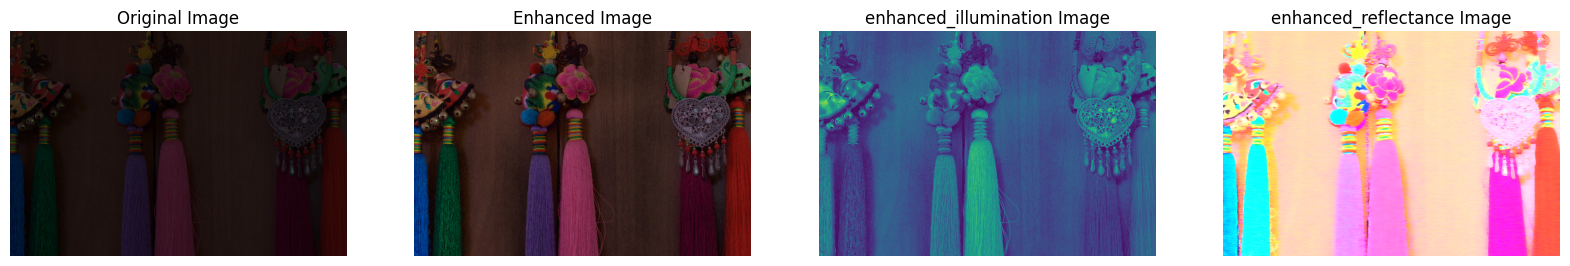

In [ ]:
import matplotlib.pyplot as plt
import imageio
import numpy as np
from skimage.restoration import denoise_tv_chambolle
from scipy.ndimage import gaussian_filter

# Load the color image
# Decompose the image
# image_path = obj_dct[cont[6]][30]
image_path = images[4]
# Load the image
image = cv2.imread(image_path, cv2.IMREAD_COLOR)
# image = cv2.resize(image, (20, 20), interpolation=cv2.INTER_LINEAR)



def calculate_neighborhood_variance(image, x, y, neighborhood_size, max_var, min_var):
    """
    Calculate the variance of pixel values in the neighborhood of (x, y)
    """
    row_start = max(y - neighborhood_size, 0)
    row_end = min(y + neighborhood_size + 1, image.shape[0])
    col_start = max(x - neighborhood_size, 0)
    col_end = min(x + neighborhood_size + 1, image.shape[1])

    neighborhood = image[row_start:row_end, col_start:col_end]
    variance = np.var(neighborhood, axis=(0, 1))
    if np.max(variance) > max_var:
      max_var = np.max(variance)
    if np.min(variance) <= min_var:
      min_var = np.min(variance)
    return variance, max_var, min_var

def construct_illumination_component(image, neighborhood_size, variance_threshold, max_var, min_var):
    """
    Construct the illumination component based on neighborhood variance
    """
    height, width, _ = image.shape
    illumination_component = np.zeros((height, width))

    for y in range(height):
        for x in range(width):
            variance, max_var, min_var = calculate_neighborhood_variance(image, x, y, neighborhood_size, max_var, min_var)
            # print(f"MX: {max_var}, MN: {min_var}")
            # if np.all(variance >= variance_threshold):
            #   print(f"[X, y]: {x, y}, variance: {variance}")
            if np.all(variance < variance_threshold):
                illumination_component[y, x] = np.mean(image[y, x])
            else:
                # Calculate average value of the neighborhood
                row_start = max(y - neighborhood_size, 0)
                row_end = min(y + neighborhood_size + 1, height)
                col_start = max(x - neighborhood_size, 0)
                col_end = min(x + neighborhood_size + 1, width)
                neighborhood = image[row_start:row_end, col_start:col_end]
                illumination_component[y, x] = np.mean(neighborhood)

    return illumination_component, max_var, min_var


# Placeholder for Retinex decomposition
def estimate_illumination_map(image):
    # Use np.max with axis=2 to find the maximum across the color channels (R, G, B)
    illumination_map = np.max(image, axis=2)
    return illumination_map

def estimate_reflectance(image, illumination_map):
    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        reflectance = image / illumination_map[:, :, None]
        reflectance[~np.isfinite(reflectance)] = 0  # Replace infinities and NaNs with 0
    return reflectance

# TV-ADMM denoising (using skimage's denoise_tv_chambolle as a placeholder)
def tv_admm_denoising(reflectance, weight=0.2):
    denoised = np.zeros_like(reflectance)
    for i in range(reflectance.shape[2]):  # Apply denoising channel-wise
        denoised[:, :, i] = denoise_tv_chambolle(reflectance[:, :, i], weight=weight, channel_axis=False)
    return denoised

# Tikhonov regularization for illumination enhancement
def enhance_illumination_tikh(illumination, lambda_reg=1.0, num_iter=100, learning_rate=0.01):
    enhanced_illumination = np.copy(illumination)

    for _ in range(num_iter):
        grad = 2 * (enhanced_illumination - illumination)  # Data fidelity term
        grad += 2 * lambda_reg * gaussian_filter(enhanced_illumination, sigma=2, order=2)  # Regularization term
        enhanced_illumination -= learning_rate * grad

    return enhanced_illumination


def enhance_illumination_cl(image):

    # Apply histogram equalization to the illumination map
    # Convert to 8-bit for histogram equalization
    illumination_map_8bit = (image * 255).astype(np.uint8)
    # equalized_illumination = cv2.equalizeHist(illumination_map_8bit) / 255.0
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_illumination = clahe.apply(illumination_map_8bit) / 255.0

    return equalized_illumination

def apply_gamma_correction(image, gamma=1.5):
    # Apply gamma correction
    gamma_corrected = np.power(image, gamma)
    return gamma_corrected


max_var = -np.inf
min_var = np.inf


if image is None:
    print("Error loading image")
else:
    # Convert BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert image to float32 for more precision in calculations
    image_float = np.float32(image_rgb) / 255.0

    # Estimate the illumination map
    neighborhood_size = 5  # Example size, can be adjusted
    variance_threshold = 300  # Example threshold, can be adjusted
    # illumination = estimate_illumination_map(image_float)
    illumination, max_var, min_var = construct_illumination_component(image_rgb, neighborhood_size, variance_threshold, max_var, min_var)

    # print(f"MX: {max_var}, MN: {min_var}")
    illumination = np.float32(illumination) / 255.0
    # Estimate the reflectance component
    reflectance_max = estimate_reflectance(image_float, illumination)


# Enhance the reflectance component using TV-ADMM denoising
enhanced_reflectance = tv_admm_denoising(reflectance, weight=0.25)

# reflectance_gamma_corrected = apply_gamma_correction(enhanced_reflectance, gamma=0.2)

# print(illumination.shape)
# # Apply Tikhonov regularization to the illumination component

enhanced_illumination = enhance_illumination_cl(illumination.squeeze())

lambda_reg = 0.25  # Example value for lambda
# enhanced_illumination = enhance_illumination_tikh(enhanced_illumination.squeeze(), lambda_reg)
# illumination_gamma_corrected = apply_gamma_correction(enhanced_illumination)
# Recombine the components
final_image = enhanced_reflectance * enhanced_illumination[:, :, np.newaxis]
# final_image = enhanced_reflectance * illumination_gamma_corrected[:, :, np.newaxis]

# Display the original and final images
plt.figure(figsize=(20, 10))

# Original image
plt.subplot(1, 4, 1)
plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')

# Final (processed) image
plt.subplot(1, 4, 2)
plt.imshow(np.clip(final_image, 0, 1))  # Clip values to valid range [0, 1]
plt.title('Enhanced Image')
plt.axis('off')

# Final (processed) image
plt.subplot(1, 4, 3)
plt.imshow(np.clip(enhanced_illumination, 0, 1))  # Clip values to valid range [0, 1]
plt.title('enhanced_illumination Image')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(np.clip(enhanced_reflectance, 0, 1))  # Clip values to valid range [0, 1]
plt.title('enhanced_reflectance Image')
plt.axis('off')

plt.show()

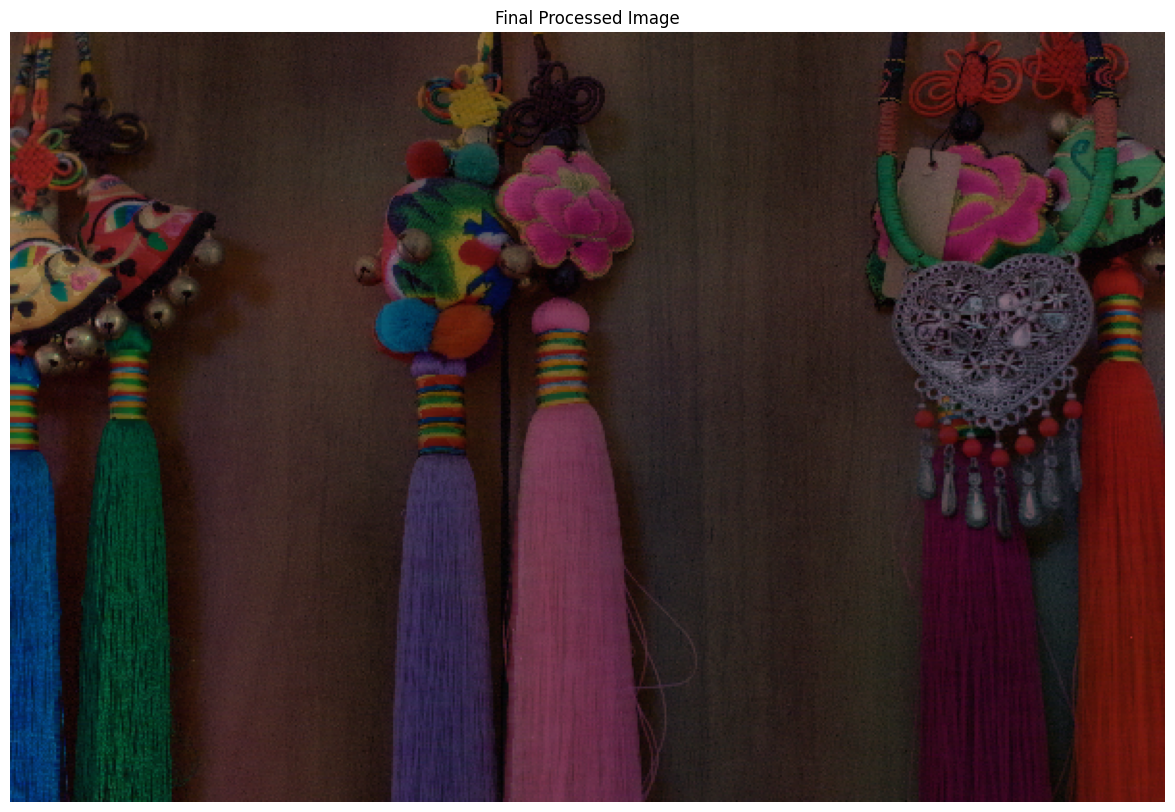

In [ ]:
# Display the original and final images
plt.figure(figsize=(20, 10))

# Original image
plt.subplot(2, 4, 1)
plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')

# Final (processed) image
plt.subplot(2, 4, 2)
plt.imshow(illumination_map)  # Clip values to valid range [0, 1]
plt.title('illumination_map Image')
# plt.savefig(os.path.join(data, "Project Codes", "Results", "var_illm.png"), dpi=400)
plt.axis('off')

# Final (processed) image

plt.subplot(2, 4, 3)
plt.imshow(illumination_mx)  # Clip values to valid range [0, 1]
plt.title('illumination_mx Image')
# plt.savefig(os.path.join(data, "Project Codes", "Results", "max_illm.png"), dpi=400)
plt.axis('off')

plt.subplot(2, 4, 4)
plt.imshow(illumination_mn)  # Clip values to valid range [0, 1]
plt.title('illumination_mn Image')
# plt.savefig(os.path.join(data, "Project Codes", "Results", "mean_illm.png"), dpi=400)
plt.axis('off')

plt.subplot(2, 4, 5)
plt.imshow(reflectance)  # Clip values to valid range [0, 1]
plt.title('reflectance Image')
# plt.savefig(os.path.join(data, "Project Codes", "Results", "var_refl.png"), dpi=400)
plt.axis('off')

plt.subplot(2, 4, 6)
plt.imshow(reflectance_mx)  # Clip values to valid range [0, 1]
plt.title('reflectance_mx Image')
# plt.savefig(os.path.join(data, "Project Codes", "Results", "max_refl.png"), dpi=400)
plt.axis('off')

plt.subplot(2, 4, 7)
plt.imshow(reflectance_mn)  # Clip values to valid range [0, 1]
plt.title('reflectance_mn Image')
# plt.savefig(os.path.join(data, "Project Codes", "Results", "mean_refl.png"), dpi=400)
plt.axis('off')

# plt.subplot(2, 4, 8)
plt.imshow(final_image)  # Clip values to valid range [0, 1]
plt.title('Final Processed Image')
plt.savefig(os.path.join(data, "Project Codes", "Results", "final_pr.png"), dpi=400)
plt.axis('off')

plt.show()